In [312]:
import urllib.request
import pprint as pp
import datetime, pymysql, json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from modeldb import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, and_
import numpy as np
%matplotlib inline



# -*- coding: utf-8 -*--

#검색 기준 시간 돌리려면 주석친부분의 days 부분을 변경해주세요
#검색기준시간 ~ 일주일전으로 검색
with open("hyuna_data.json", "r", encoding="utf8") as f:
    contents = f.read()
    json_data = json.loads(contents)
    
user = json_data["users"][0]["user"]
password = json_data["users"][0]["password"]
host = json_data["users"][0]["host"]
port = json_data["users"][0]["port"]
kobis_key = json_data["users"][0]["kobis_key"]

engine = create_engine('mysql+pymysql://%s:%s@%s:%s/%s?charset=utf8'%(user,password,host,port,DB))
Session = sessionmaker(bind=engine)
session = Session()

Base = declarative_base()
Base.metadata.create_all(engine)
conn= engine.connect()

#영화명, 관객수, 조회일 크롤링해온다음 디비에 저장시킴, 저장시킨걸 데이터프레임으로 보여줌
def get_movie_audiance_num_per_date(input_date, time_section):
    #params : week or month

    input_date = datetime.datetime.strptime(input_date,'%Y-%m-%d')
    searching_date = []
    
    if not input_date:
        print("오늘날짜 업데이트가 되지 않았어요ㅜㅜ 어제날짜로 검색하시겠습니까?")
    
    while time_section:
        searching_date.append(input_date.strftime("%Y%m%d"))
        input_date -= datetime.timedelta(days=1)
        time_section -= 1


    movie_info_per_date = {}
    for date_time in searching_date:
        base_url = urllib.request.urlopen(f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key={kobis_key}&targetDt={date_time}")
        sources = json.load(base_url)
        movie_infos = sources["boxOfficeResult"]['dailyBoxOfficeList']
    
        audiacc_per_movie = {}
        for movie_info in movie_infos:
            audiacc_per_movie[movie_info['movieNm']] = movie_info['audiCnt']
        movie_info_per_date[date_time] = audiacc_per_movie


    movie_table = pd.DataFrame(movie_info_per_date)
    movie_table["sum"] = movie_table.sum(axis = 1)
    movie_table = movie_table.sort_values(by = "sum", ascending= False)[:5]
    del movie_table["sum"]
    
    insert_into_db(movie_table)
    return movie_table

#인섵하는 함수. 헬프함수
def insert_into_db(movie_table):
    movie_table = pd.DataFrame(movie_table).fillna(-1)
    for movie_name, section_audi in zip(movie_table.index, movie_table.values):
        for search_date,today_audi in zip(movie_table.keys(), section_audi):
            search_date = datetime.datetime.strptime(search_date,'%Y%M%d').date()
            if today_audi != -1 : 
                add_movie_info = kobis_movie_info(movie_name, search_date, today_audi)
                session.merge(add_movie_info)
    session.commit()
            
    return "Inserted Succesfully"


#디비에있는것 그래프로 그려줌
def query_and_draw(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date,'%Y-%M-%d').date()
    end_date = datetime.datetime.strptime(end_date,'%Y-%M-%d').date()
    query = pd.DataFrame(session.query(kobis_movie_info.movie_name, kobis_movie_info.search_date,kobis_movie_info.today_audi).filter(start_date >= kobis_movie_info.search_date).filter(kobis_movie_info.search_date >= end_date).all())
    movie_table =  pd.DataFrame(index = list(set(query.movie_name)), columns = sorted(list(set(query.search_date))))
    
    for i in query.values:
        movie_table.loc[movie_table.index == i[0] , movie_table.columns == i[1]] = i[2]
    movie_table["sum"] = movie_table.sum(axis = 1)
    movie_table = movie_table.sort_values(by = "sum", ascending= False)[:5]
    del movie_table["sum"]
    del query
    
    movie_table.columns = movie_table.columns.map(lambda x : x.strftime('%Y%m%d'))
    movie_name = list(movie_table.index)
    date_time = movie_table.columns
    auc_rate = movie_table.values

    plt.figure(figsize = (15,12))
    for i in auc_rate:
        plt.plot(date_time,i, marker = "o")
    plt.xlabel("Date")
    plt.ylabel("AudiAcc")
    plt.autoscale(enable = True, axis = "y")
    
    
    font_name = fm.FontProperties(fname = "./font/NanumGothic.ttf").get_name()
    plt.rc('font', family = font_name)
    plt.legend(movie_name, loc = "best")
    return plt.show()

session.close()

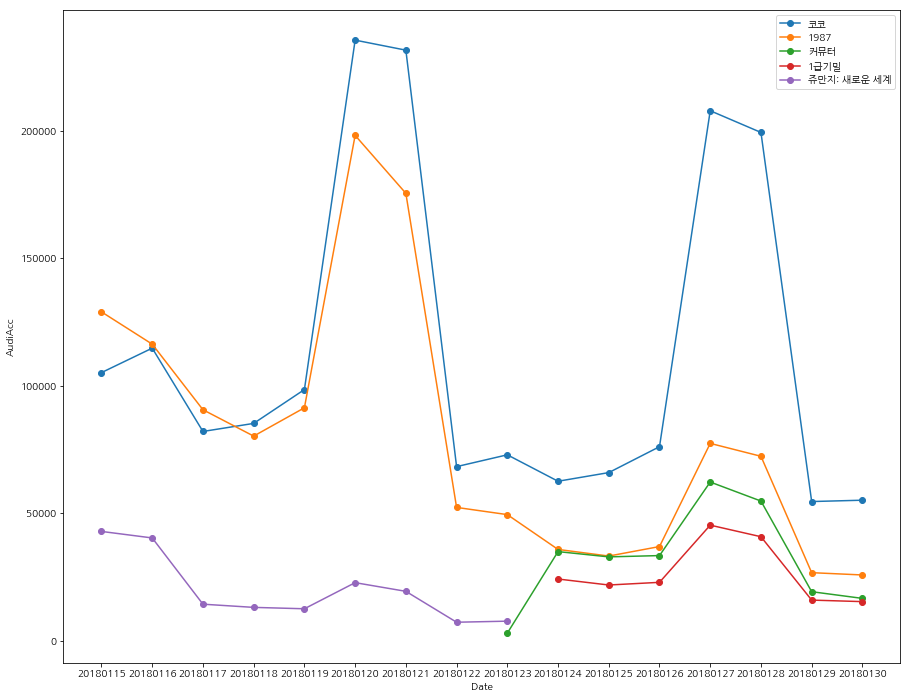

In [313]:
query_and_draw('2018-01-30','2018-01-15')

In [306]:
def show_movie_trend_graph(movie_table):
    
    movie_name = list(movie_table.index)
    date_time = movie_table.columns
    auc_rate = movie_table.values

    plt.figure(figsize = (30,20))
    for i in auc_rate:
        plt.plot(date_time,i, marker = "o")
    plt.xlabel("Date")
    plt.ylabel("AudiAcc")
    plt.autoscale(enable = True, axis = "y")
    
    font_name = fm.FontProperties(fname = "./font/NanumGothic.ttf").get_name()
    plt.rc('font', family = font_name)
    plt.legend(movie_name, loc = "best")
    return plt.show()


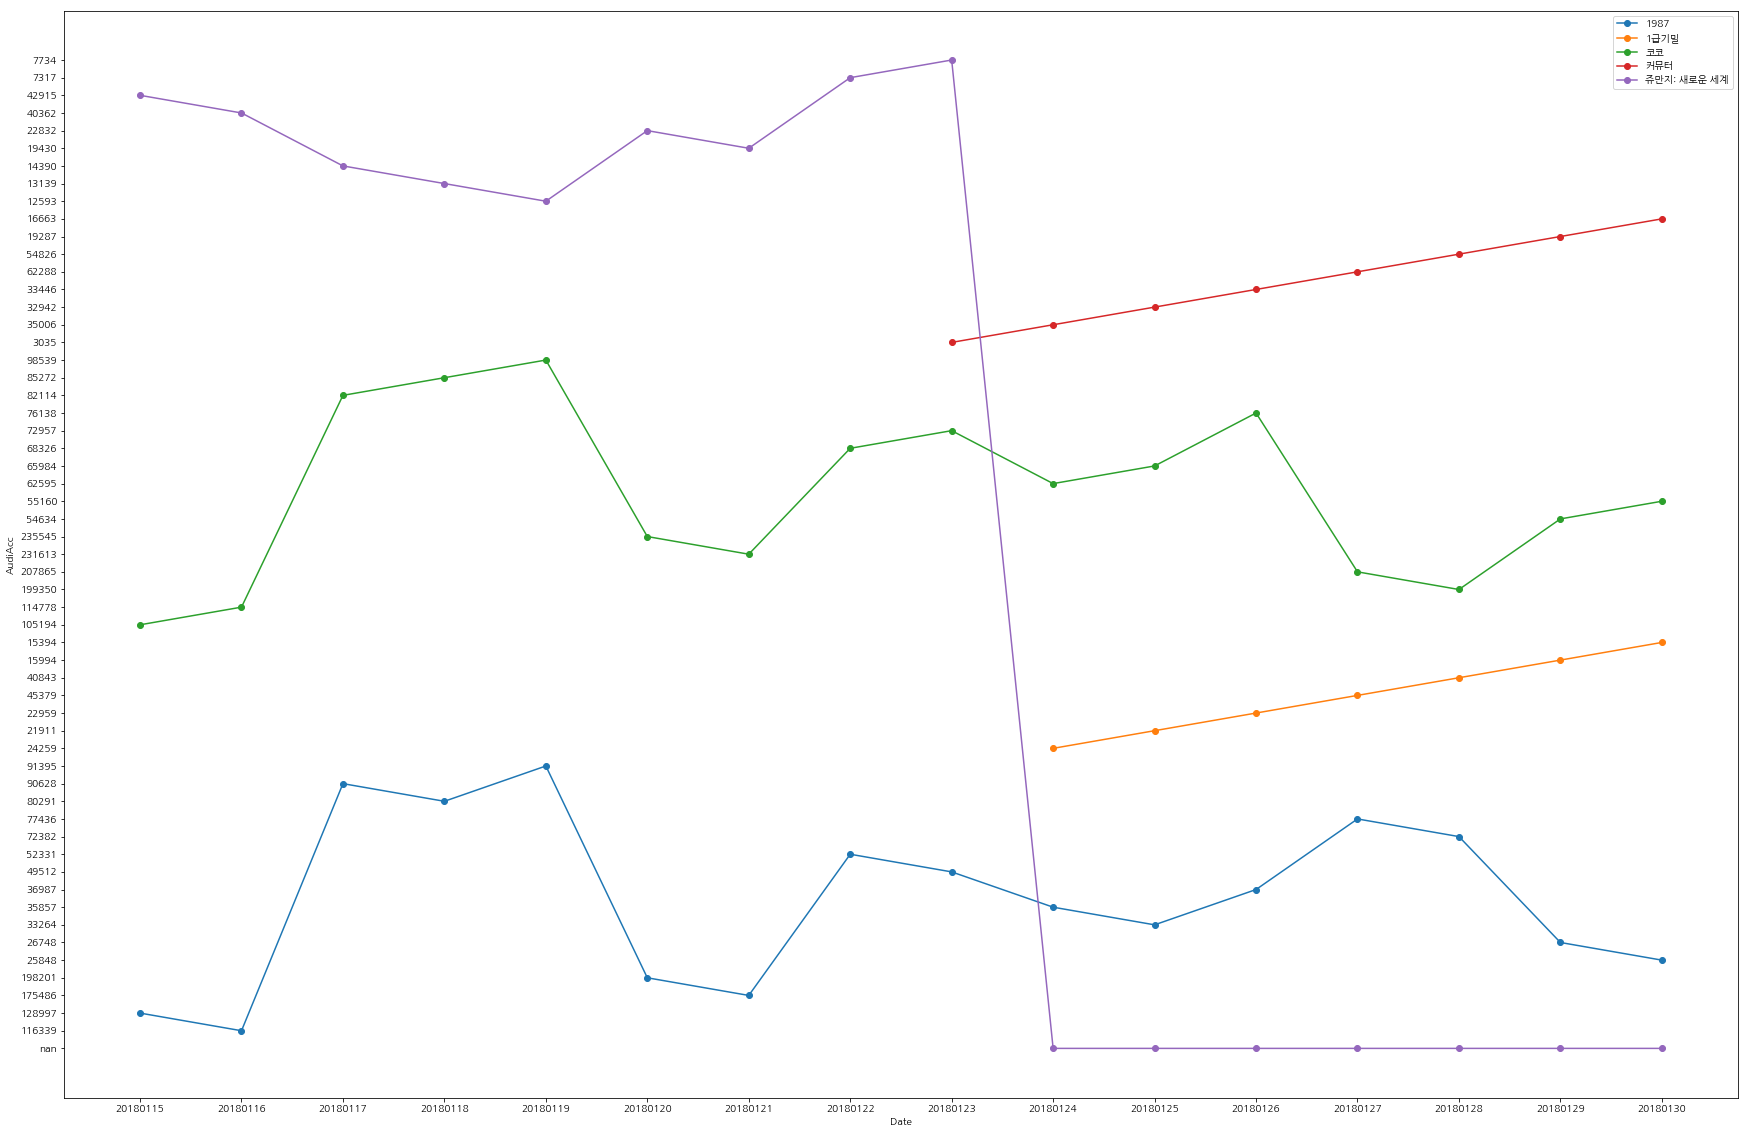

In [300]:
movie_table = get_movie_audiance_num_per_date('2018-01-30',16)
# insert_into_db(movie_table)
show_movie_trend_graph(movie_table)

In [298]:
movie_table

AttributeError: 'function' object has no attribute 'to_frame'

In [47]:
query_and_draw()

,20180601,20180531
독전,193594.0,142368.0
데드풀 2,51379.0,41960.0
어벤져스: 인피니티 워,13433.0,10136.0
트루스 오어 데어,11660.0,6991.0
한 솔로: 스타워즈 스토리,7859.0,6288.0


In [12]:
# movie_table

NameError: name 'Null' is not defined

In [18]:
# datetime.datetime.today() - datetime.datetime.strftime("2018-06-05","%Y%m%d")
# (datetime.datetime.today()- datetime.datetime.strptime("2018-06-05",'%Y-%m-%d'))

In [14]:
day = 7
today = datetime.datetime.today() - datetime.timedelta(days=2)
searching_date = []
while day:
    day -= 1
    today -= datetime.timedelta(days=1)
    searching_date.append(today.strftime("%Y%m%d"))


movie_info_per_date = {}
for date_time in searching_date:
    base_url = urllib.request.urlopen(f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=430156241533f1d058c603178cc3ca0e&targetDt={date_time}")
    sources = json.load(base_url)
    movie_infos = sources["boxOfficeResult"]['dailyBoxOfficeList']
    
    audiacc_per_movie = {}
    for movie_info in movie_infos:
        audiacc_per_movie[movie_info['movieNm']] = int(movie_info['audiCnt'])
    movie_info_per_date[date_time] = audiacc_per_movie


week_table = pd.DataFrame(movie_info_per_date).fillna(0)
week_table["sum"] = week_table.sum(axis = 1) 
week_table = week_table.sort_values(by = "sum", ascending= False)[:5]
del week_table["sum"]

movie_name = list(week_table.index)
date_time = week_table.columns
auc_rate = week_table.values

week_table

,20180530,20180531,20180601,20180602,20180603,20180604,20180605
독전,299943.0,142368.0,193594.0,421770.0,366235.0,117689.0,155534.0
데드풀 2,81820.0,41960.0,51379.0,101866.0,77417.0,27514.0,35154.0
어벤져스: 인피니티 워,16391.0,10136.0,13433.0,31033.0,27224.0,8639.0,12503.0
트루스 오어 데어,15342.0,6991.0,11660.0,25023.0,21812.0,5673.0,7904.0
한 솔로: 스타워즈 스토리,14721.0,6288.0,7859.0,15880.0,13280.0,3553.0,4864.0


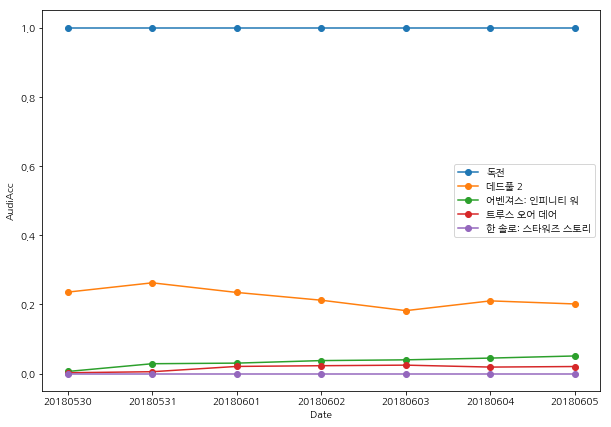

In [15]:
movie_trend_graph("week")